In [2]:
import importlib
import src.utils.config_loader
importlib.reload(src.utils.config_loader)

from src.utils.config_loader import ConfigLoader

config_loader = ConfigLoader()
all_configs = config_loader.load_configs()
base_configs = config_loader.get_section(all_configs, "base")
graph_configs = config_loader.get_section(all_configs, "graph")
community_cfg = config_loader.get_section(all_configs, "community")

In [3]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}") # type: ignore

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

PyTorch version: 2.5.1
CUDA available: True
CUDA version: 12.4


device(type='cuda')

In [4]:
# Preprocess data
import importlib
import src.modules.data_processor
importlib.reload(src.modules.data_processor)

from src.modules.data_processor import DataProcessor

print(base_configs)
data_processor = DataProcessor(base_configs=base_configs)
processed_data = data_processor.run(device=device, summarize=False)

{'paths': {'raw': 'data/raw/deb_label.csv', 'processed': 'data/processed'}, 'labels': {0: 'disagree', 1: 'neutral', 2: 'agree'}, 'subreddits': {'brexit': 0, 'blacklivesmatter': 1, 'climate': 2, 'democrats': 3, 'republican': 4}, 'required_columns': ['label', 'msg_id_parent', 'msg_id_child', 'submission_id', 'body_parent', 'body_child', 'submission_text', 'subreddit', 'author_parent', 'author_child', 'datetime', 'agreement_fraction', 'individual_kappa'], 'cleaning': {'normalize_subreddits': True, 'rename_columns': {'author_child': 'src_author', 'author_parent': 'dst_author', 'msg_id_child': 'src_comment_id', 'msg_id_parent': 'dst_comment_id', 'body_child': 'src_comment_text', 'body_parent': 'dst_comment_text', 'datetime': 'timestamp'}, 'timestamp_parsing': {'primary_format': '%d/%m/%Y %H:%M', 'dayfirst': True, 'error_handling': 'coerce', 'fallback_formats': ['%Y-%m-%d %H:%M:%S', '%m/%d/%Y %H:%M', '%Y-%m-%d']}, 'remove_self_replies': True}, 'temporal': {'infer_parent_comment_time': {'enab

In [6]:
# Build graphs
import importlib
import src.modules.graph_processor
importlib.reload(src.modules.graph_processor)

from src.modules.graph_processor import GraphProcessor

processed_path = base_configs.get('processed_path', 'data/processed')
pairs = processed_data.user_pairs
comments = processed_data.comments

graph_processor = GraphProcessor(graph_configs=graph_configs, processed_path=processed_path)
graph_data = graph_processor.run(pairs=pairs, embeddings_source=comments)

Building node features with pooling: mean
    + Total unique authors in pairs: 35257
    + Total pooled vectors: 35212
    + Pooled vector dimension: 384
Building graph snapshots: directed=True, wcc_mode=min_edges, edge_attrs=['mean_confidence', 'net_vector']
[Subreddit 0, T0] [WCC:min_edges] Nodes 32->29, Edges 86->84 (2.3% edges removed)
[Subreddit 0, T1] [WCC:min_edges] Nodes 30->30, Edges 79->79 (0.0% edges removed)
[Subreddit 0, T2] [WCC:min_edges] Nodes 31->31, Edges 59->59 (0.0% edges removed)
[Subreddit 0, T3] [WCC:min_edges] Nodes 43->43, Edges 107->107 (0.0% edges removed)
[Subreddit 0, T4] [WCC:min_edges] Nodes 53->53, Edges 134->134 (0.0% edges removed)
[Subreddit 0, T5] [WCC:min_edges] Nodes 71->71, Edges 266->266 (0.0% edges removed)
[Subreddit 0, T6] [WCC:min_edges] Nodes 79->79, Edges 187->187 (0.0% edges removed)
[Subreddit 0, T7] [WCC:min_edges] Nodes 96->94, Edges 177->176 (0.6% edges removed)
[Subreddit 0, T8] [WCC:min_edges] Nodes 187->187, Edges 611->611 (0.0% edg

/home/jovyan/github/ecs_msc_project/src/modules/graph_processor.py:177: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/torch/csrc/utils/tensor_new.cpp:278.)
  x = torch.tensor(node_features, dtype=torch.float)


    + Created 77 PyG graphs
Saved PyG graphs to data/processed/pyg_graphs_384D.pt


In [7]:
# Import the ECS processor
from src.modules.ecs_processor import ECSProcessor, create_ecs_processor

ckpt_path = "checkpoints/best_model_2509011326.pth"
model_class_path = "src.models.multitask_debate_gnn.MultitaskDebateGNN"

ecs_processor = create_ecs_processor(
    base_configs=base_configs,
    community_configs=community_cfg,
    gnn_model_path=ckpt_path,
    gnn_model_class_path=model_class_path,
    device=device   # type: ignore
)

# Process all graphs
pyg_graphs, graph_dict = graph_data.pyg_graphs, graph_data.graph_dict
processed_dict = ecs_processor.process_graphs(pyg_graphs, graph_dict)

# Get results DataFrame
ecs_df = ecs_processor.get_results_dataframe()
print(f"Processed {len(processed_dict)} subreddits")

# Map subreddit to timestep interval from replies data
subreddit_timestep_intervals = processed_data.replies[['subreddit_id', 'subreddit', 'timestep', 'interval', 'actual_window_size']].drop_duplicates().sort_values(['timestep', 'interval']).reset_index(drop=True)
interval_mapping = processed_data.replies[['subreddit_id', 'timestep', 'interval', 'actual_window_size']].drop_duplicates()
ecs_df_with_intervals = ecs_df.merge(
    interval_mapping,
    on=['subreddit_id', 'timestep'],
    how='left'
)

# Save ecs dataframe
ecs_df_with_intervals.to_csv("results/ecs/all_ecs_data.csv", index=False)
ecs_df_with_intervals.head()
print("Saved results/ecs/all_ecs_data.csv")

Loading model checkpoint from checkpoints/best_model_2509011326.pth


Loaded GNN model: MultitaskDebateGNN
Starting ECS processing for 77 graphs
Processing graph for subreddit: 0, timestep: 0
  Extracted node mapping: 29 nodes
  Graph stats: 29 nodes, 84 edges
Using device: cuda
  Communities found: 3
  Community sizes (min=6): [np.int64(13), np.int64(10), np.int64(6)]
  Modularity: 0.238
  EchoGAE ECI: 0.4924 | Community ECIs: ['0.3954', '0.6624', '0.4193']
  DebateGNN ECI: 0.5260 | Community ECIs: ['0.5841', '0.4688', '0.4954']
  **Embedding-Community Alignment Analysis**
    EchoGAE Embedding-Community Alignment:
    Silhouette Score: -0.0960 (higher = better separation)
    + Avg Intra-Community Distance: 0.6872
    + Avg Inter-Community Distance: 0.7225
    + Distance Ratio (Inter/Intra): 1.0515
    DebateGNN Embedding-Community Alignment:
    Silhouette Score: -0.0412 (higher = better separation)
    + Avg Intra-Community Distance: 0.4792
    + Avg Inter-Community Distance: 0.5173
    + Distance Ratio (Inter/Intra): 1.0797
  **End Alignment Analysi

Running complete ECS analysis with figure generation...
   + Color mode: lineage
Starting complete ECS analysis with pre-computed results...
Analyzing community evolution...
Computing evolution for brexit across 23 timesteps: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

--- Timestep 0 -> 1 ---
Communities: 3 -> 2
Total Jaccard (Hungarian): 0.448
User Retention: 72.4%

--- Timestep 1 -> 2 ---
Communities: 2 -> 2
Total Jaccard (Hungarian): 0.400
User Retention: 70.0%

--- Timestep 2 -> 3 ---
Communities: 2 -> 4
Total Jaccard (Hungarian): 0.310
User Retention: 74.2%

--- Timestep 3 -> 4 ---
Communities: 4 -> 4
Total Jaccard (Hungarian): 0.669
User Retention: 79.1%

--- Timestep 4 -> 5 ---
Communities: 4 -> 3
Total Jaccard (Hungarian): 0.596
User Retention: 86.8%

--- Timestep 5 -> 6 ---
Communities: 3 -> 2
Total Jaccard (Hungarian): 0.462
User Retention: 78.9%

--- Timestep 6 -> 7 ---
Communities: 2 -> 2
Total Jaccard (Hungarian): 0.344
User Retentio

,n_timesteps,modularity,echogae_eci,debgnn_eci,delta_echogae_eci,delta_debgnn_eci,echogae_silhouette,debgnn_silhouette
blacklivesmatter,10,0.852 ± 0.069,0.472 ± 0.014,0.403 ± 0.07,0.006 ± 0.016,0.01 ± 0.061,-0.212 ± 0.038,-0.324 ± 0.104
brexit,23,0.161 ± 0.14,0.462 ± 0.076,0.481 ± 0.037,0.002 ± 0.094,-0.002 ± 0.043,-0.103 ± 0.147,-0.067 ± 0.068
climate,26,0.431 ± 0.242,0.466 ± 0.032,0.399 ± 0.053,-0.001 ± 0.032,0.0 ± 0.061,-0.129 ± 0.068,-0.254 ± 0.105
democrats,9,0.18 ± 0.109,0.414 ± 0.025,0.307 ± 0.04,0.004 ± 0.04,0.006 ± 0.056,-0.197 ± 0.048,-0.404 ± 0.078
republican,9,0.342 ± 0.122,0.421 ± 0.021,0.299 ± 0.046,-0.001 ± 0.033,0.0 ± 0.044,-0.198 ± 0.038,-0.431 ± 0.089
ALL,77,0.365 ± 0.279,0.454 ± 0.051,0.402 ± 0.081,0.001 ± 0.057,0.001 ± 0.052,-0.148 ± 0.101,-0.245 ± 0.159



Summary table saved to: results/ecs/ecs_summary_table.csv

RESULTS SUMMARY
DATASET OVERVIEW:
   + Subreddits analyzed: 5
   + Total timesteps: 77
   + Total communities: 927

METHOD COMPARISON:
   + EchoGAE ECI: 0.454 ± 0.050
   + DebateGNN ECI: 0.402 ± 0.080
   + Paired t-test: t = 6.565, p = 0.000
   + Effect size (Cohen's d): 0.753 (medium)
   + Significant difference: Yes

COMMUNITY EVOLUTION (r/brexit - ID 0):
   + Average Jaccard similarity: 0.418
   + Average retention rate: 75.5%
   + Average growth rate: 36.7%

Generating result figures...
Using color mode: lineage
Using specified subreddit ID: 0


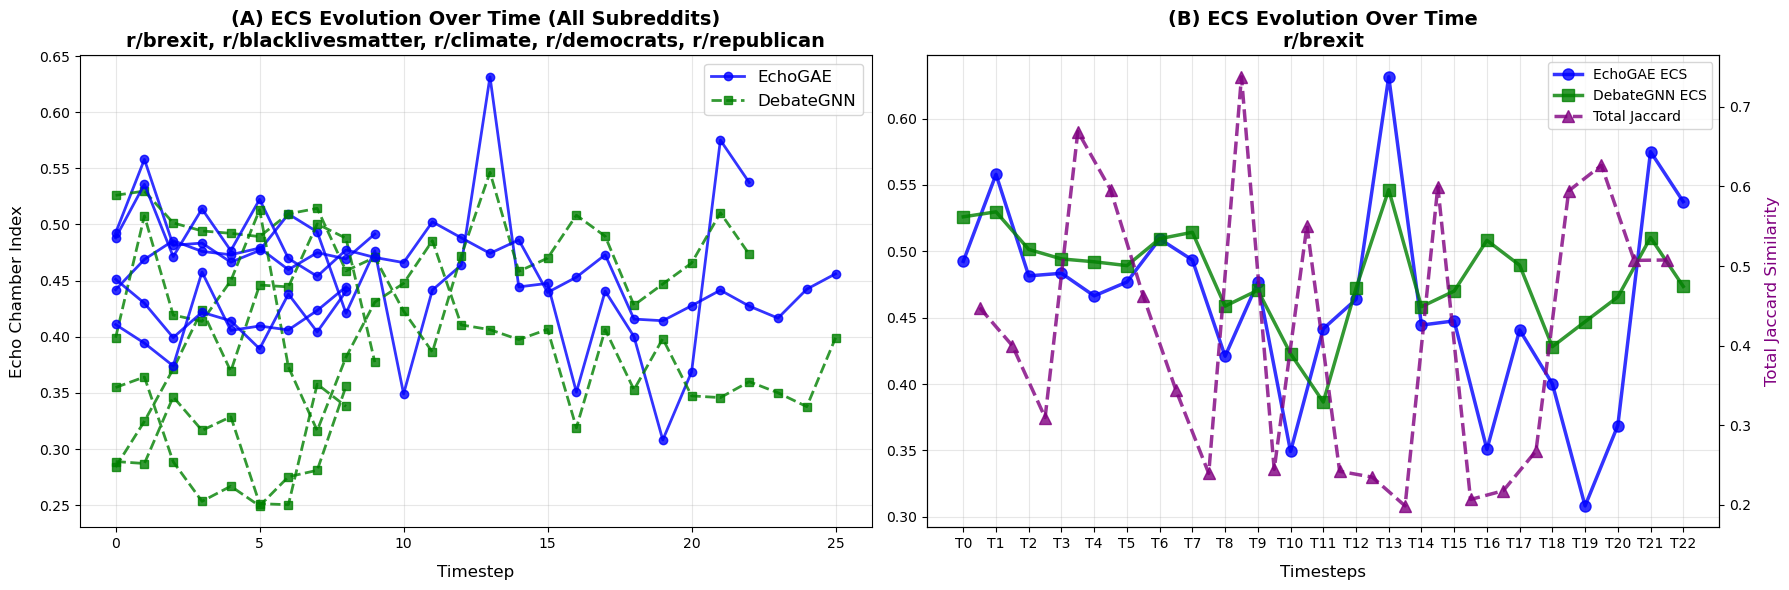

Debug - evolution_data type: <class 'dict'>
Debug - evolution_data keys: ['timesteps', 'ts_pairs', 'jaccard_matrices', 'hungarian_matches', 'total_jaccards', 'migration_stats', 'comm_ids_t1', 'comm_ids_t2']


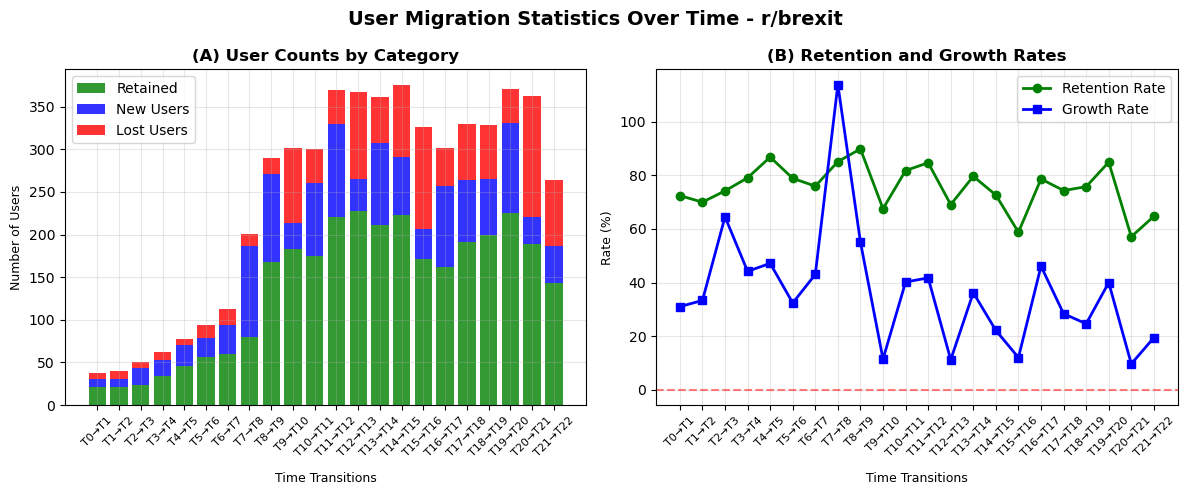

Plotting embedding comparison for timestep 12
  Overlap between nx_nodes and partition keys: 330/330
  Using lineage colors consistent with Sankey diagrams
Using 32 colors for lineage mode
Max communities per timestep: 7
  Community color map: {np.int64(0): '#808080', np.int64(1): '#800080', np.int64(2): '#FFFF00', np.int64(3): '#008080', np.int64(4): '#000000', np.int64(5): '#FFA500'}


/opt/conda/envs/mscenv/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/opt/conda/envs/mscenv/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/opt/conda/envs/mscenv/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaW

  NetworkX coloring: 330 nodes with colors, 0 nodes without colors
  Community layout: 6 communities for positioning


<Figure size 640x480 with 0 Axes>

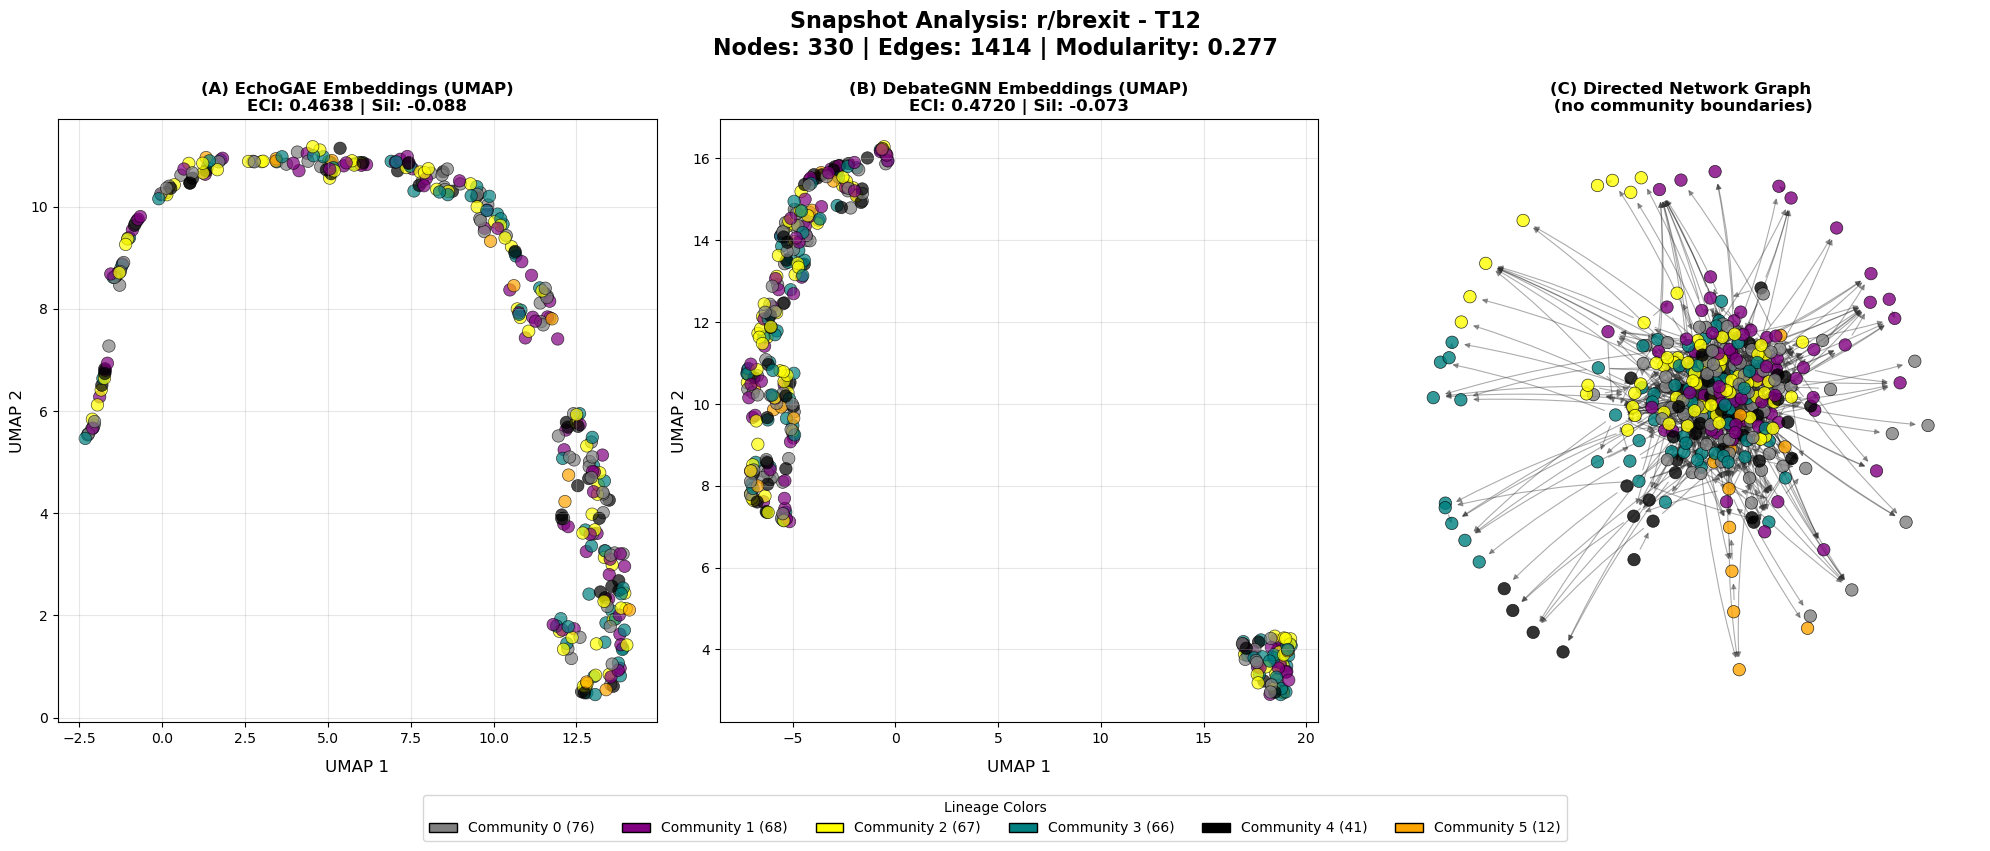


SNAPSHOT SUMMARY r/brexit - T12
Communities: 6
Nodes: 330
Edges: 1414
Modularity: 0.277
EchoGAE ECI: 0.4638
DebateGNN ECI: 0.4720
Color scheme: Lineage Colors
Boundaries drawn: False
  Community 0: 76 nodes, EchoGAE ECI: 0.4695, DebateGNN ECI: 0.4926
  Community 1: 68 nodes, EchoGAE ECI: 0.5244, DebateGNN ECI: 0.4521
  Community 2: 67 nodes, EchoGAE ECI: 0.4744, DebateGNN ECI: 0.4652
  Community 3: 66 nodes, EchoGAE ECI: 0.4110, DebateGNN ECI: 0.4597
  Community 4: 41 nodes, EchoGAE ECI: 0.4507, DebateGNN ECI: 0.4925
  Community 5: 12 nodes, EchoGAE ECI: 0.3599, DebateGNN ECI: 0.4910
Generating Figure 6: Network Evolution Grid...
  Using lineage colors for network evolution grid
Using 32 colors for lineage mode
Max communities per timestep: 7
Generating network evolution grid with 23 timesteps
Using color mode: lineage
Network evolution grid saved to: results/ecs/figure6_network_evolution_grid.png


<Figure size 640x480 with 0 Axes>

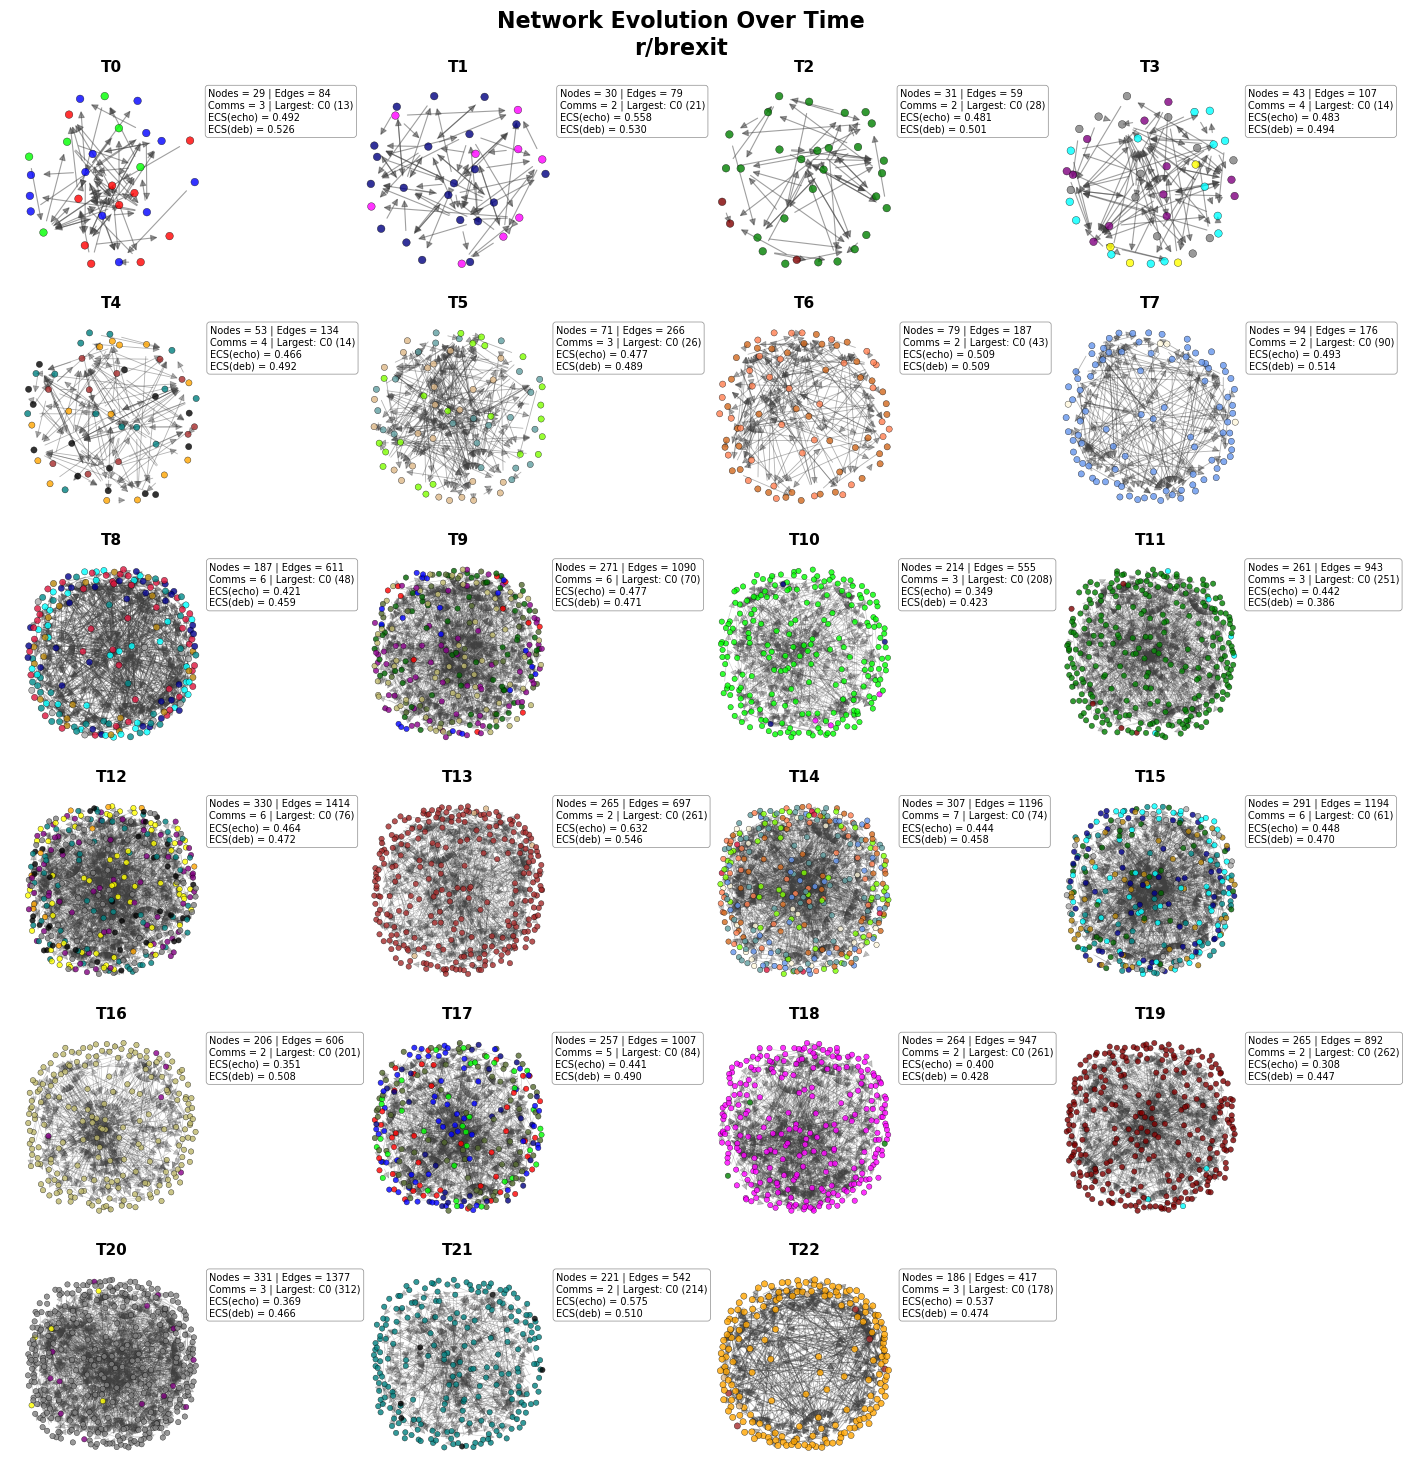

Saved to results/ecs/{test_sub_summary.subreddit[0]}_ecs_data.csv


,subreddit,timestep,interval,num_nodes,num_edges,modularity,num_communities,echogae_eci,debgnn_eci
0,brexit,0,2016-06-21 - 2017-10-13,29,84,0.238,3,0.492,0.526
1,brexit,1,2017-10-14 - 2017-12-12,30,79,0.213,2,0.558,0.530
2,brexit,2,2017-12-13 - 2018-02-10,31,59,0.064,2,0.481,0.501
3,brexit,3,2018-02-11 - 2018-04-11,43,107,0.305,4,0.483,0.494
4,brexit,4,2018-04-12 - 2018-06-10,53,134,0.328,4,0.466,0.492
5,brexit,5,2018-06-11 - 2018-08-09,71,266,0.279,3,0.477,0.489
6,brexit,6,2018-08-10 - 2018-10-08,79,187,0.296,2,0.509,0.509
7,brexit,7,2018-10-09 - 2018-12-07,94,176,0.033,2,0.493,0.514
8,brexit,8,2018-12-08 - 2019-02-05,187,611,0.339,6,0.421,0.459
9,brexit,9,2019-02-06 - 2019-04-06,271,1090,0.303,6,0.477,0.471


In [8]:
import importlib
import src.visualization.ecs_plots
import src.visualization.snapshot_plots
import src.visualization.community_migration_plots
import src.visualization.community_sankey_plots
import src.utils.community_colors
importlib.reload(src.utils.community_colors)
importlib.reload(src.visualization.snapshot_plots)
importlib.reload(src.visualization.ecs_plots)
importlib.reload(src.visualization.community_migration_plots)
importlib.reload(src.visualization.community_sankey_plots)

import src.analysis.ecs_analyzer
importlib.reload(src.analysis.ecs_analyzer)

from src.analysis.ecs_analyzer import ECSAnalyzer

analyzer = ECSAnalyzer(output_dir='results/ecs')
TEST_SUB_ID = 0
TEST_SUB_TS = 12

results = analyzer.run_complete_analysis_with_figures(
    processed_dict=processed_dict,
    ecs_df=ecs_df,
    target_subreddit_id=TEST_SUB_ID,
    embedding_timestep=TEST_SUB_TS,
    # plot_all_embedding_timesteps=True,
    save_figures=True,
    color_mode="lineage"
)

# Display and save test subreddit ecs statistics
test_sub_summary = ecs_df_with_intervals[ecs_df_with_intervals['subreddit_id'] == TEST_SUB_ID][['subreddit', 'timestep', 'interval', 'num_nodes', 'num_edges', 'modularity', 'num_communities', 'echogae_eci', 'debgnn_eci']]
test_sub_summary.to_csv(f"results/ecs/{test_sub_summary.subreddit[0]}_ecs_data.csv", index=False)
print("Saved to results/ecs/{test_sub_summary.subreddit[0]}_ecs_data.csv")

display(test_sub_summary)